In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Importance(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Importance(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/22/2019 17:03:24 ELBO=-4.35906677e+02 at epoch 1
02/22/2019 17:03:24 ELBO=-4.20791748e+02 at epoch 2
02/22/2019 17:03:25 ELBO=-4.40552246e+02 at epoch 3
02/22/2019 17:03:25 ELBO=-4.29457153e+02 at epoch 4
02/22/2019 17:03:25 ELBO=-4.39525574e+02 at epoch 5
02/22/2019 17:03:25 ELBO=-3.93387360e+02 at epoch 6
02/22/2019 17:03:25 ELBO=-4.07466919e+02 at epoch 7
02/22/2019 17:03:26 ELBO=-4.37418549e+02 at epoch 8
02/22/2019 17:03:26 ELBO=-4.26843750e+02 at epoch 9
02/22/2019 17:03:26 ELBO=-4.29513245e+02 at epoch 10
02/22/2019 17:03:26 ELBO=-4.00716553e+02 at epoch 11
02/22/2019 17:03:27 ELBO=-4.41554657e+02 at epoch 12
02/22/2019 17:03:27 ELBO=-3.90986847e+02 at epoch 13
02/22/2019 17:03:27 ELBO=-4.15105530e+02 at epoch 14
02/22/2019 17:03:27 ELBO=-3.92944244e+02 at epoch 15
02/22/2019 17:03:27 ELBO=-3.97806030e+02 at epoch 16
02/22/2019 17:03:28 ELBO=-4.06162781e+02 at epoch 17
02/22/2019 17:03:28 ELBO=-4.10835815e+02 at epoch 18
02/22/2019 17:03:28 ELBO=-3.93653107e+02 at epoch 19
02

Epoch   513: reducing learning rate of group 0 to 5.0000e-02.


02/22/2019 17:05:15 ELBO=-1.23277275e+02 at epoch 516
02/22/2019 17:05:15 ELBO=-1.23519051e+02 at epoch 517
02/22/2019 17:05:15 ELBO=-1.21374916e+02 at epoch 518
02/22/2019 17:05:16 ELBO=-1.20310280e+02 at epoch 519
02/22/2019 17:05:16 ELBO=-1.16672981e+02 at epoch 520
02/22/2019 17:05:16 ELBO=-1.17088333e+02 at epoch 521
02/22/2019 17:05:16 ELBO=-1.28251083e+02 at epoch 522
02/22/2019 17:05:16 ELBO=-1.13088364e+02 at epoch 523
02/22/2019 17:05:17 ELBO=-1.17172714e+02 at epoch 524
02/22/2019 17:05:17 ELBO=-1.10488525e+02 at epoch 525
02/22/2019 17:05:17 ELBO=-1.09496971e+02 at epoch 526
02/22/2019 17:05:17 ELBO=-1.23860107e+02 at epoch 527
02/22/2019 17:05:17 ELBO=-1.21084373e+02 at epoch 528
02/22/2019 17:05:18 ELBO=-9.36458969e+01 at epoch 529
02/22/2019 17:05:18 ELBO=-1.05486824e+02 at epoch 530
02/22/2019 17:05:18 ELBO=-1.10260681e+02 at epoch 531
02/22/2019 17:05:18 ELBO=-1.13813240e+02 at epoch 532
02/22/2019 17:05:18 ELBO=-1.17360939e+02 at epoch 533
02/22/2019 17:05:19 ELBO=-1.

Epoch   659: reducing learning rate of group 0 to 2.5000e-02.


02/22/2019 17:05:46 ELBO=-9.92341156e+01 at epoch 661
02/22/2019 17:05:46 ELBO=-1.05990562e+02 at epoch 662
02/22/2019 17:05:46 ELBO=-1.02655556e+02 at epoch 663
02/22/2019 17:05:46 ELBO=-9.65560684e+01 at epoch 664
02/22/2019 17:05:46 ELBO=-9.29424591e+01 at epoch 665
02/22/2019 17:05:47 ELBO=-9.54343109e+01 at epoch 666
02/22/2019 17:05:47 ELBO=-9.63621750e+01 at epoch 667
02/22/2019 17:05:47 ELBO=-9.80385895e+01 at epoch 668
02/22/2019 17:05:47 ELBO=-9.61410370e+01 at epoch 669
02/22/2019 17:05:47 ELBO=-9.82335968e+01 at epoch 670
02/22/2019 17:05:48 ELBO=-9.55136414e+01 at epoch 671
02/22/2019 17:05:48 ELBO=-9.58313446e+01 at epoch 672
02/22/2019 17:05:48 ELBO=-9.46649094e+01 at epoch 673
02/22/2019 17:05:48 ELBO=-7.93118210e+01 at epoch 674
02/22/2019 17:05:48 ELBO=-9.00311584e+01 at epoch 675
02/22/2019 17:05:49 ELBO=-7.59351120e+01 at epoch 676
02/22/2019 17:05:49 ELBO=-9.11527252e+01 at epoch 677
02/22/2019 17:05:49 ELBO=-9.35062103e+01 at epoch 678
02/22/2019 17:05:49 ELBO=-9.

Epoch   822: reducing learning rate of group 0 to 1.2500e-02.


02/22/2019 17:06:21 ELBO=-9.60120850e+01 at epoch 825
02/22/2019 17:06:21 ELBO=-8.81312790e+01 at epoch 826
02/22/2019 17:06:21 ELBO=-8.96031342e+01 at epoch 827
02/22/2019 17:06:22 ELBO=-9.20817719e+01 at epoch 828
02/22/2019 17:06:22 ELBO=-9.28732605e+01 at epoch 829
02/22/2019 17:06:22 ELBO=-9.07899323e+01 at epoch 830
02/22/2019 17:06:22 ELBO=-8.93728714e+01 at epoch 831
02/22/2019 17:06:22 ELBO=-8.83206787e+01 at epoch 832
02/22/2019 17:06:23 ELBO=-9.06529922e+01 at epoch 833
02/22/2019 17:06:23 ELBO=-8.93132629e+01 at epoch 834
02/22/2019 17:06:23 ELBO=-8.79935379e+01 at epoch 835
02/22/2019 17:06:23 ELBO=-8.81531677e+01 at epoch 836
02/22/2019 17:06:24 ELBO=-8.46619186e+01 at epoch 837
02/22/2019 17:06:24 ELBO=-9.19061279e+01 at epoch 838
02/22/2019 17:06:24 ELBO=-9.31598053e+01 at epoch 839
02/22/2019 17:06:24 ELBO=-8.56848297e+01 at epoch 840
02/22/2019 17:06:24 ELBO=-8.65424576e+01 at epoch 841
02/22/2019 17:06:25 ELBO=-7.61314087e+01 at epoch 842
02/22/2019 17:06:25 ELBO=-9.

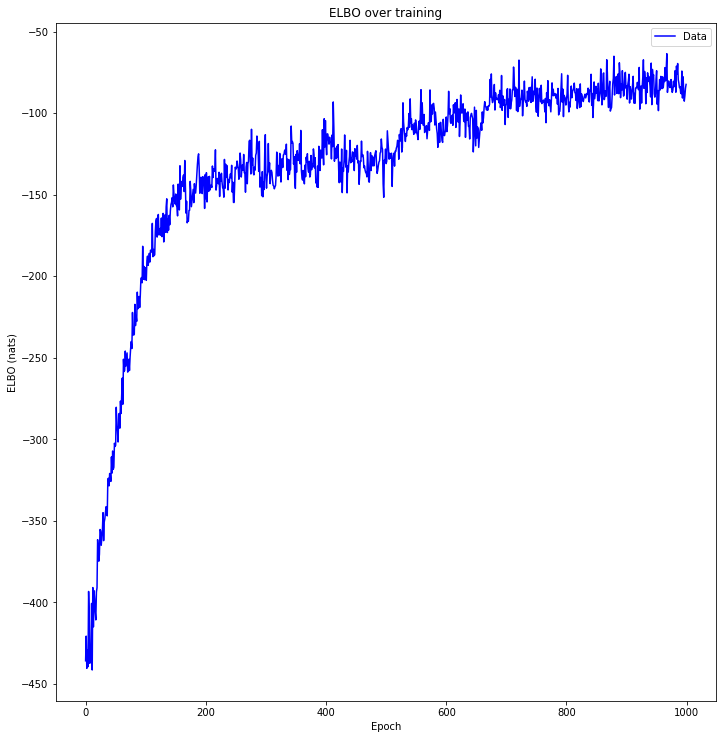

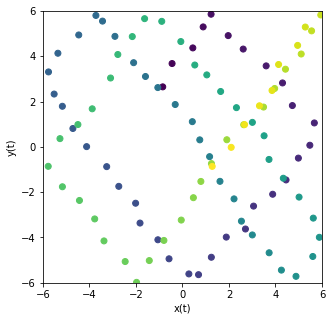

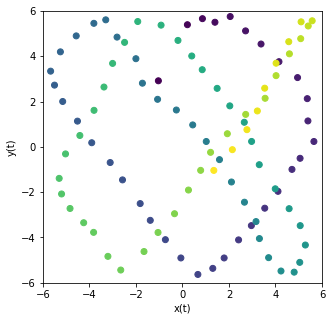

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.8454, -1.7409], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.3562, -2.5311], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.7987,  0.0000],\n        [ 0.0092, -1.7306]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-1.1766,  3.0541], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.2295, -1.2345], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.3279, -2.3381], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 0.8076,  0.6875],\n        [ 0.5133,  0.7759],\n        [ 0.4998,  0.3522],\n        [ 0.6721, -0.6163],\n        [ 0.7099, -0.6114],\n        [ 0.8622, -0.7130],\n        [ 0.7430, -0.7889],\n        [ 0.5343, -0.8996],\n        [ 0.8529, -0.7882],\n        [ 0.7752, -0.9238],\n        [-0.5941, -0.6597],\n        [-0.5704, -0.8387],\n        [-0.5742, -0.6398],\n        [-0.6956, -0.6614],\n        [-0.5070, -0.7898],\n        [-0.7161, -0.5633],\n        [-0.6566, -0.7726],\n

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-0.8480,  2.6509])
Position at time 1 tensor([-0.4461,  3.6806])
Position at time 2 tensor([0.4458, 4.3705])
Position at time 3 tensor([0.8905, 5.2975])
Position at time 4 tensor([1.2315, 5.8581])
Position at time 5 tensor([1.9679, 4.9139])
Position at time 6 tensor([2.6131, 4.3194])
Position at time 7 tensor([3.6002, 3.5769])
Position at time 8 tensor([4.3040, 2.8240])
Position at time 9 tensor([4.7279, 1.8253])
Position at time 10 tensor([5.6727, 1.0577])
Position at time 11 tensor([5.4793, 0.0733])
Position at time 12 tensor([ 4.9864, -0.4950])
Position at time 13 tensor([ 4.4560, -1.4587])
Position at time 14 tensor([ 3.8806, -2.0904])
Position at time 15 tensor([ 3.0586, -2.6139])
Position at time 16 tensor([ 2.7096, -3.6250])
Position at time 17 tensor([ 1.8851, -3.9823])
Position at time 18 tensor([ 1.2430, -4.8718])
Position at time 19 tensor([ 0.6916, -5.6408])
Position at time 20 tensor([ 0.2762, -5.6080])
Position at time 21 tensor([-0.5769, -4.940

In [24]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-1.0352,  2.9186])
Inferred position at time 1 tensor([0.2129, 5.3951])
Inferred position at time 2 tensor([0.8594, 5.6620])
Inferred position at time 3 tensor([1.3977, 5.5035])
Inferred position at time 4 tensor([2.0533, 5.7557])
Inferred position at time 5 tensor([2.7146, 5.1226])
Inferred position at time 6 tensor([3.3801, 4.5418])
Inferred position at time 7 tensor([4.1510, 3.7629])
Inferred position at time 8 tensor([4.9508, 3.0609])
Inferred position at time 9 tensor([5.3689, 2.1308])
Inferred position at time 10 tensor([5.3969, 1.1467])
Inferred position at time 11 tensor([5.6541, 0.2389])
Inferred position at time 12 tensor([ 5.0595, -0.5034])
Inferred position at time 13 tensor([ 4.7108, -0.9933])
Inferred position at time 14 tensor([ 4.1089, -1.9619])
Inferred position at time 15 tensor([ 3.5398, -2.7062])
Inferred position at time 16 tensor([ 2.9644, -3.4749])
Inferred position at time 17 tensor([ 2.4141, -4.1055])
Inferred position at tim

In [25]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [26]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-1.2639,  3.1265])
Inferred position at time 1 tensor([0.0757, 4.7945])
Inferred position at time 2 tensor([0.8208, 5.4003])
Inferred position at time 3 tensor([1.2089, 5.6610])
Inferred position at time 4 tensor([1.8188, 5.6971])
Inferred position at time 5 tensor([2.3538, 5.0262])
Inferred position at time 6 tensor([3.0849, 4.4094])
Inferred position at time 7 tensor([3.9267, 3.7343])
Inferred position at time 8 tensor([4.6739, 2.9241])
Inferred position at time 9 tensor([5.1106, 2.1124])
Inferred position at time 10 tensor([5.4739, 1.1057])
Inferred position at time 11 tensor([5.5241, 0.5352])
Inferred position at time 12 tensor([ 5.0418, -0.1061])
Inferred position at time 13 tensor([ 4.7191, -0.8445])
Inferred position at time 14 tensor([ 4.1676, -1.5338])
Inferred position at time 15 tensor([ 3.3676, -2.1448])
Inferred position at time 16 tensor([ 2.7538, -2.8765])
Inferred position at time 17 tensor([ 2.0963, -3.5032])
Inferred position at tim

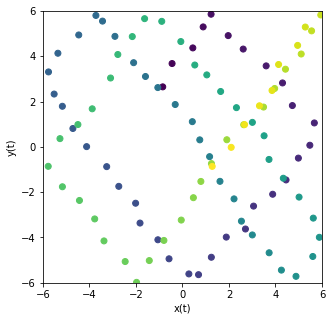

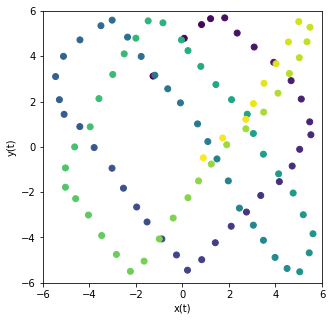

In [27]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)